In [72]:
### Allen B Davis
### Yale University
###
### First year project
### Summer 2015

# RVOS_Kepler will create RV observations of a star with one planet, create a periodogram with FAP,
# fit a Keplerian, and return uncertainities in the planet's mass and orbital parameters

In [73]:
# Imports
from time import strftime
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
import pickle
from lmfit import minimize, Parameters, Parameter, report_fit

%matplotlib inline


plt.close()

In [74]:
# Constants

### Constants, all in SI unless otherwise specified
mEarth = 5.97219E24
mJup = 1.898E27 
mSun = 1.9891E30 
G = 6.67384E-11
au = 149597870700. 
day = 86400.
year = 365.256363004*day
pi = math.pi
today = 2457129.53734 #JD

In [75]:
#Eventually make a Star class that calls Planet classes.

class Planet:
    
    def __init__(self,mass,period,massStar,ecc,incl,w,t0):
        
        self.mass = mass #in mEarth
        self.period = period #in years
        self.massStar = massStar #in mSun. Default: 1 solar mass
        self.ecc = ecc #eccentricity. Default: 0.2
        self.incl = incl #inclination in degrees. Default: 90.
        self.sini = np.sin(incl*pi/180.) #sin(i)
        
        def getSMA():
            totmass = (self.mass*mEarth)+(massStar*mSun)
            return (1/au) * ( ( (self.period*year)**2 * G*totmass ) / ( 4.*pi*pi))**(1./3.)
        
        self.sma = getSMA() #semimajor axis in AU. Given uniquely by mass, massStar, and period.
        
        if w==None:
            self.w = 2.*pi*np.random.random() #phase. default: random phase from [0,2pi)
        else:
            self.w = w
            
        self.t0 = t0 #JD of start. default: "today"
        self.tp = t0+(np.random.random()*period) #periastron time. Default: random from [today,today+period)   
        self.K = (2.*pi*G/(self.period*day))**(1./3.) * (self.mass*mEarth*self.sini) * ((self.massStar*mSun)**(-2./3.)) * (1./np.sqrt(1.-self.ecc**2.))
        #The above formula gives the correct value of K given Earth/Sun inputs. So VERIFIED.
        self.params = [self.period,self.ecc,self.tp,self.w,self.K,self.mass]
        self.params_print = [self.period,self.ecc,self.tp-self.t0,self.w*180./pi,self.K,self.mass]
        


In [76]:
# Will eventually handle multiple planets
def observe_star(planets,ndays,
                 offset_threshold=2./24.):
    #planets is an array of planets
    for p in planets:
        # Make all the random offsets first; we will draw from this list for each obs.
        roffsets = [np.random.random()*(2*offset_threshold) - (offset_threshold) for i in range(ndays)] 
        rnext = 0 #tracks the next element of the random list to pull from
        
        # Create the list of observation times according to the blind Doppler survey strategy
        obsList = np.arange(0,3) + roffsets[rnext:rnext+3]
        rnext = obsList.size
        
        if scatter(p,obsList+p.t0,False) > p.std_True: # Keep a separation of 1 day
            newtimes = np.arange(obsList.size,ndays)
            obsList = np.concatenate((obsList,newtimes+roffsets[rnext:ndays]))
            #print zip(np.arange(obsList.size),obsList),'\n'
        else: # Ramp it up to 5 day separation
            sep = 5 #separation in days b/w next obs
            n = 3 #how many more obs this round
            newtimes = np.arange(obsList.size-1+sep,obsList.size+n*sep,sep)
            obsList = np.concatenate((obsList,newtimes+roffsets[rnext:rnext+n]))
            rnext = obsList.size
            #print zip(np.arange(obsList.size),obsList),'\n'
            if scatter(p,obsList+p.t0 > p.std_True,False): # Keep a 5 day separation
                n = ndays - obsList.size + 1
                newtimes = np.arange(obsList[obsList.size-1]+sep,obsList[obsList.size-1]+n*sep,sep)
                obsList = np.concatenate((obsList,newtimes+roffsets[rnext:ndays]))
                #print zip(np.arange(obsList.size),obsList),'\n'
            else: # Ramp it up to 10 day separation and keep it there
                sep = 10
                n = ndays-obsList.size + 1
                newtimes = np.arange(obsList[obsList.size-1]+sep,obsList[obsList.size-1]+n*sep,sep)        
                obsList = np.concatenate((obsList,newtimes+roffsets[rnext:ndays]))
                #print zip(np.arange(obsList.size),obsList),'\n'
        
        # Set the JD
        p.obsList = obsList + p.t0
        
        #record true RV curve
        f = calcTrueAnomaly(p.period,p.tp,p.ecc,p.obsList)
        p.RV_True = p.K*(np.cos(p.w+f) + p.ecc*np.cos(p.w))
        
        #add jitter scaled to a normal distribution
        errList = np.random.normal(0, p.std_True, ndays)
        
        #record observed RV curve
        p.RV_Obs = p.RV_True + errList
        
        #record observated scatter in RV curve
        p.std_Obs = np.std(p.RV_Obs)

In [77]:
def scatter(p,obsList,lastThree):
        f = calcTrueAnomaly(p.period,p.tp,p.ecc,obsList)
        p.RV_True = p.K*(np.cos(p.w+f) + p.ecc*np.cos(p.w))
        if(lastThree):
            size = np.size(p.RV_True)
            return np.std(p.RV_True[size-3:size])
        else:
            return np.std(p.RV_True)


# Calculates the true anomaly from the time and orbital elements.
def calcTrueAnomaly(P, tp, e, t):

    phase = (t-tp)/P #phase at each obsList time
    M = 2.*pi*(phase - np.floor(phase)) #Mean Anom array: at each obsList time
    E1 = calcKepler(M, np.array([e]))

    n1 = 1. + e
    n2 = 1. - e

    #True Anomaly:
    return 2.*np.arctan(np.sqrt(n1/n2)*np.tan(E1/2.))


#returns Eccentric anomaly, given mean anomaly and eccentricity
def calcKepler(Marr_in, eccarr_in):


    nm = np.size(Marr_in)
    nec = np.size(eccarr_in)

    if nec == 1 and nm > 1:
        eccarr = eccarr_in #[eccarr_in for x in range(nm)]
    else:
        eccarr = eccarr_in

    if nec > 1 and nm == 1:
        Marr = Marr_in #[Marr_in for x in range(nec)]
    else:
        Marr = Marr_in

    conv = 1.E-12 #threshold for convergence
    k = 0.85 #some parameter for guessing ecc
    ssm = np.sign(np.sin(Marr))
    Earr = Marr+(ssm*k*eccarr)  #first guess at E
    fiarr = (Earr-(eccarr*np.sin(Earr))-Marr)  #E - e*sin(E)-M    ; should go to 0 when converges
    convd = np.where(abs(fiarr) > conv) #which indices are unconverged

    count = 0
    while np.size(convd) > 0:
        count += 1

        M = np.copy(Marr[convd]) #we only run the unconverged elements
        ecc = eccarr #[convd] ??
        E = np.copy(Earr[convd])
        fi = np.copy(fiarr[convd])

        fip = 1.-ecc*np.cos(E) #;d/dE(fi) ;i.e.,  fi^(prime)
        fipp = ecc*np.sin(E)  #;d/dE(d/dE(fi)) ;i.e.,  fi^(\prime\prime)
        fippp = 1.-fip #;d/dE(d/dE(d/dE(fi))) ;i.e.,  fi^(\prime\prime\prime)

        d1 = -fi/fip                             #;first order correction to E
        d2 = -fi/(fip+(d1*fipp/2.))                #;second order correction to E
        d3 = -fi/(fip+(d2*fipp/2.)+(d2*d2*fippp/6.)) #;third order correction to E

        E += d3 #apply correction to E

        #print np.size(Earr),np.size(E)
        Earr[convd] = E #update values

        fiarr = (Earr-eccarr*np.sin(Earr)-Marr)     #;how well did we do?
        convd = np.where(abs(fiarr) > conv)   #;test for convergence; update indices

        if count > 100:
#             print "WARNING!  Kepler's equation not solved!!!"
            break

    return Earr


def getMsini(pl):
    return 

In [272]:
### Solving orbit with LMfit

def solveOrbit(pl,P_G,periodList,niter,boot_data=None,guesses=None,flag=None):

    # define objective function: returns the array to be minimized
    def func(params, t, data):
        """ model decaying sine wave, subtract data"""
        P = params['P'].value
        e = params['e'].value
        tp = params['tp'].value
        h = params['h'].value
        c = params['c'].value
        v0 = params['v0'].value

        f = calcTrueAnomaly(P, tp, e, t)

        model = h*np.cos(f) + c*np.sin(f) + v0
        return model - data
    
    #initialize array of parameters
    params_array = [None]*niter
    result_array = [None]*niter
    chisq_array = [None]*niter
    
    #save some guesses that would otherwise be calculated many times
    p_guess = periodList[np.argmax(P_G)]
    
    # Do a bunch of fits
    for n in range(0,niter):
    
        # create a set of Parameters
        params = Parameters()
        params.add('P', value= p_guess, min=0)
        params.add('e', value= 0.05 + 0.7*np.random.random(), min=0)
        params.add('tp', value= pl.t0+(np.random.random()*p_guess))
        params.add('h', value= 4.*np.random.random()-2.) #prev guess 1
        params.add('c', value= 4.*np.random.random()-2.) #prev guess 1
        params.add('v0', value= 0.5*np.random.random()-0.25) #prev guess 0.1

        # do fit, here with leastsq model
        result = minimize(func, params, args=(pl.obsList, pl.RV_Obs))
        
        # get chisq, which we will use to decide if this is the best fit
        chisq = np.sum(result.residual**2)
        
        # save params, result, and chisq
        params_array[n] = params
        result_array[n] = result
        chisq_array[n] = chisq
#         print 'trial',n,'chisq=',chisq
    
    # Continue, now using the best fit according to chisq
    n_best = np.argmin(chisq_array)
    print 'best trial:',n_best
    params = params_array[n_best]
    result = result_array[n_best]
    
    # calculate final result
    final = pl.RV_Obs + result.residual
    
    # write error report
    report_fit(params)
    
    # Fitted params = [P,e,tp,h,c,v0]
    p_opt = params['P'].value
    e_opt = params['e'].value
    tp_opt = params['tp'].value
    
    w_opt = (np.arctan(-params['c'].value/params['h'].value))%(2.*pi) #[0-2pi) rads
    c,h = params['c'].value, params['h'].value
    if ((c>0 and h>0) or (c<0 and h<0)): #ie, if the numerator is negative,
        if 0 <= w_opt < pi: #ie, if sin(w) is currently positive, then pick w so that it's negative
            w_opt = (w_opt-pi)%(2.*pi) #condition from RVlin paper (see eqn 9)
            print "aaaaaaaaa"
    else: #ie, the numerator is positive
        if pi <= w_opt < 2.*pi: #ie, if sin(w) is currently negative, then pick w so that it's positive
            w_opt = (w_opt-pi)%(2.*pi) #condition from RVlin paper (see eqn 9)
            print "bbbbbbb"

    K_opt = np.sqrt(params['h'].value**2 + params['c'].value**2)#params['v0'].value/(e_opt*np.cos(w_opt))
    print '(sqrth^2+c^2)-(v0/ecosw):',np.sqrt(params['h'].value**2 + params['c'].value**2) - (params['v0'].value/(e_opt*np.cos(w_opt)))
    
    ################ KLUDGE #################
    F1 = False
    
    if params['v0'].value*(e_opt*np.cos(w_opt)) < 0:
        print '****** PRIMARY KLUDGE *******'
        w_opt = (w_opt-pi)%(2.*pi)
        if not (pi/2. <= w_opt < 3.*pi/2.):
            K_opt = K_opt*-1.
    
    #F1 failures
    if params['v0'].value < 0 and h*c < 0:
        print '******* F1 FAILURE *******'
        w_opt = (w_opt-pi)%(2.*pi)
        F1 = True
        
    #F2 failures
    if (not F1) and params['v0'].value > 0 and h*c > 0:
        print '******* F2 FAILURE *******'
        w_opt = (w_opt-pi)%(2.*pi)
    
    ############## END KLUDGE ###############
    
    msini_fit = (1./mEarth) * (K_opt) * ((2.*pi*G/(p_opt*day))**(-1./3.)) * ((pl.massStar*mSun)**(2./3.)) * (np.sqrt(1-e_opt**2.))
    
    params_out = np.array([p_opt,e_opt,tp_opt,w_opt,K_opt,msini_fit])

    f_opt = calcTrueAnomaly(p_opt,tp_opt,e_opt,pl.obsList)
    RV_fit = K_opt*(np.cos(w_opt+f_opt) + e_opt*np.cos(w_opt))

    if "boot" != flag:
        pl.RV_fit = RV_fit
        pl.params_out = params_out
        pl.params_out_print = np.array([p_opt,e_opt,tp_opt-pl.t0,w_opt*180./pi,K_opt,msini_fit])
        pl.params_LMfit = params

    if "boot" == flag:
        return params_out, RV_fit

In [273]:
class Simulator:
    def __init__(self,nobs,sigma,
                 jitter=0.0,massStar=1.0,massPlanet=5.0, period=15.,
                 ecc=0.2,incl=90.,w=None,t0=today,
                 pmin=0.1,pmax=500.,pres=0.01,
                 threshold_FAP=1.0,FAP_niter=100,
                 orbit_niter=100):

        self.std_True = np.sqrt(sigma**2 + jitter**2)
        self.periodList = np.linspace(pmin,pmax,num=pmax/pres)
        self.freqList = 2.* pi / self.periodList
        
        ###### Run simulation
        
        # Create a planet object with given astrophysical parameters
#         print 'Creating planet:',strftime("%H:%M:%S")
        p = Planet(massPlanet,period,massStar,ecc,incl,w,t0)
        
        # Create observations according to blind survey strategy
#         print 'Observing star:',strftime("%H:%M:%S")
        p.std_True = self.std_True
        observe_star([p],nobs)

        # Make a LS periodogram of the observations
#         print 'Making initial pgram:',strftime("%H:%M:%S")
        p.P_G = sp.signal.lombscargle(p.obsList, p.RV_Obs,self.freqList)
        
        # Fit Keplerian to determine orbital parameters
#         print 'Fitting initial Keplerian:',strftime("%H:%M:%S")
        solveOrbit(p,p.P_G,self.periodList,orbit_niter)
        
        # Print and return planet's parameters
        print 'Outputing fitted parameters:',strftime("%H:%M:%S")
        print p.params_out
        print '\nInjected parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg\nSemiamplitude = {4:.2f} m/s\nMass = {5:.2f} M_e'.format(*p.params_print)
        print '\nFitted parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg\nSemiamplitude = {4:.2f} m/s\nMsini = {5:.2f} M_e'.format(*p.params_out_print)
        
        # Save planet(s)
        self.planet = p

In [274]:
def makePlot(sim,numpoints=500,fill=True):
    
    p = sim.planet
        
    if fill:
        # get more data points for nicer plotting
        start,end = p.obsList[0],p.obsList[-1]
        if numpoints == -1:
            #default is 10 points per period
            numpoints = int(np.round(10*(end-start)/p.period))

        times = np.linspace(start,end,numpoints)

        f_True = calcTrueAnomaly(p.period,p.tp,p.ecc,times)
        RV_True = p.K*(np.cos(p.w+f_True) + p.ecc*np.cos(p.w))

        f_fit = calcTrueAnomaly(p.params_LMfit['P'].value,p.params_LMfit['tp'].value,p.params_LMfit['e'].value,times)
        RV_fit = p.params_out[4]*(np.cos(p.params_out[3]+f_fit) + p.params_out[1]*np.cos(p.params_out[3]))
    
        
    #Plot the RV curve
    plt.subplot(2, 1, 1)

    plt.plot(p.obsList, p.RV_Obs,'kx',label='Observed')
    
    if fill:
        plt.plot(times, RV_True,'r--',label='True')
        plt.plot(times, RV_fit, 'b--',label='Fit')
    else:
        plt.plot(p.obsList, p.RV_True,'r-',label='True')
        plt.plot(p.obsList, p.RV_fit,'b-',label='Fit')

    #     plt.errorbar(p.obsList, p.RV_Obs, yerr=p.std_True, linestyle = 'none',ecolor='r')
    plt.xlabel('Time (days)')
    plt.ylabel('RV (m/s)')
    plt.xlim(p.obsList[0],p.obsList[p.obsList.size-1])
    plt.title(r'Period = %.2f days, Mass = %.1f mEarth' % (p.period,(p.mass)))
    plt.legend()
    
    #Plot the Periodogram
    plt.subplot(2, 1, 2)

    plt.plot(sim.periodList, p.P_G, 'b-')

    # plot the significance lines.
    xlim = (np.min(sim.periodList), np.max(sim.periodList))
#     plt.plot(xlim,[p.threshold_power,p.threshold_power], 'r--', lw=1., label='FAP: %.2f%%' %(threshold_FAP))
#     plt.plot(xlim,[p.calc_FAP_power(1.),p.calc_FAP_power(1.)], 'g--', lw=1., label='FAP: 1%')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.xscale('log')
    # plt.title('Ntrials = %d' % FAP_niter)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [275]:
def makePhasePlot(sim):
    
    p = sim.planet

    #Plot a phase folded version
    plt.subplot(2, 1, 1)
    
    def phaseFold(times, period):
        return (times % period)/period

    plt.plot(phaseFold(p.obsList, p.period),p.RV_True,'b.',label='True')
    plt.plot(phaseFold(p.obsList, p.period),p.RV_Obs,'r.',label='Observed')
    plt.xlabel('Phase (given Period = %.4f)' %p.period )
    plt.ylabel('RV (m/s)')
    plt.title('True period')
    plt.tight_layout()
    plt.legend()
    
    
    plt.subplot(2,1,2)
    plt.plot(phaseFold(p.obsList, p.params_out[0]),p.RV_True,'b.',label='True')
    plt.plot(phaseFold(p.obsList, p.params_out[0]),p.RV_Obs,'r.',label='Observed')
    plt.xlabel('Phase (given Period = %.4f)' %p.params_out[0] )
    plt.ylabel('RV (m/s)')
    plt.title('Fitted period')
    plt.tight_layout()
    plt.legend()

    plt.show()

In [276]:
# def getInfo(sim):
#     info ='nObs='
    

best trial: 70
[[Variables]]
    P:    27.1162694 +/- 0.059397 (0.22%) (init= 26.58523)
    e:    0.21240468 +/- 0.007056 (3.32%) (init= 0.5651233)
    tp:   2.4571e+06 +/- 0.146428 (0.00%) (init= 2457136)
    h:    0.06489954 +/- 0.045906 (70.73%) (init= 1.994637)
    c:    1.26449301 +/- 0.009227 (0.73%) (init=-1.565324)
    v0:   0.01818375 +/- 0.011033 (60.68%) (init=-0.1704086)
[[Correlations]] (unreported correlations are <  0.100)
    C(tp, h)                     =  0.961 
    C(h, v0)                     =  0.813 
    C(tp, v0)                    =  0.782 
    C(P, tp)                     = -0.262 
    C(P, e)                      =  0.247 
    C(h, c)                      = -0.229 
    C(tp, c)                     = -0.210 
    C(c, v0)                     = -0.176 
    C(e, c)                      =  0.110 
(sqrth^2+c^2)-(v0/ecosw): -0.404031780696
******* F2 FAILURE *******
Outputing fitted parameters: 16:47:47
[  2.71162694e+01   2.12404681e-01   2.45714160e+06   1.62207589

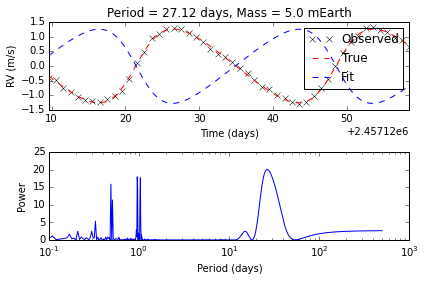

In [282]:
#### TESTING
plt.close()

sim1 = Simulator(50,0.05,massPlanet=5.,ecc=0.2,w=3*pi/2,massStar=0.8,period=27.12453)
makePlot(sim1)

plt.close()



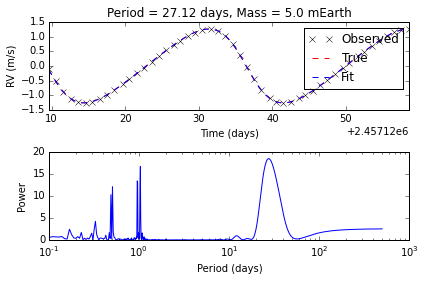

In [189]:
makePlot(sim1,fill=True,numpoints=3000)

# To do next: put in the units I looked up and wrote down today.

In [267]:
plt.close()
makePhasePlot(sim1)
plt.close()

In [ ]:
#Choose what to simulate
#pickle.dump



In [ ]:
#Choose what to plot
#pickle.load


In [188]:
plt.close()
x = np.linspace(-7,7,100)
plt.plot(x,np.sin(np.arctan(x)),'bx')
plt.plot(x,np.sin(x),'rx')
plt.plot(x,np.arctan(x),'gx')
plt.plot(x,np.tan(x),'k.')


plt.show()